In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np


df = pd.read_csv('random_forest_predictions_with_actuals.csv')
print(df.head())

                    run_date            target_datetime  predicted_Price  \
0  2025-03-15 00:00:00+00:00  2025-03-16 01:00:00+00:00         0.093036   
1  2025-03-15 00:00:00+00:00  2025-03-16 02:00:00+00:00         0.091816   
2  2025-03-15 00:00:00+00:00  2025-03-16 03:00:00+00:00         0.092445   
3  2025-03-15 00:00:00+00:00  2025-03-16 04:00:00+00:00         0.093663   
4  2025-03-15 00:00:00+00:00  2025-03-16 05:00:00+00:00         0.093793   

   actual_Price  oxygent_price  naive_price  
0       0.08579          0.083      0.08680  
1       0.07962          0.079      0.08570  
2       0.07818          0.074      0.09586  
3       0.07860          0.073      0.09772  
4       0.08051          0.076      0.09985  


# GENERAL PERFORMANCE METRICS


In [39]:
# Calculate missing values count and percentage
missing_values = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_values)

                 Missing Count  Missing Percentage
run_date                     0                0.00
target_datetime              0                0.00
predicted_Price              0                0.00
actual_Price                 0                0.00
oxygent_price                6                0.14
naive_price                  0                0.00


In [40]:
df['oxygent_price'] = df['oxygent_price'].fillna(df['predicted_Price'])

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate metrics for each model
results = {
    'Model': ['Random Forest', 'Oxygent', 'Naive'],
    'RMSE': [
        np.sqrt(mean_squared_error(df['actual_Price'], df['predicted_Price'])),
        np.sqrt(mean_squared_error(df['actual_Price'], df['oxygent_price'])),
        np.sqrt(mean_squared_error(df['actual_Price'], df['naive_price']))
    ],
    'MAE': [
        mean_absolute_error(df['actual_Price'], df['predicted_Price']),
        mean_absolute_error(df['actual_Price'], df['oxygent_price']),
        mean_absolute_error(df['actual_Price'], df['naive_price'])
    ]
}

# Create results DataFrame and round to 6 decimal places
results_df = pd.DataFrame(results).round(6)
print(results_df)

           Model      RMSE       MAE
0  Random Forest  0.035374  0.025476
1        Oxygent  0.077176  0.058853
2          Naive  0.042212  0.030525


In [42]:
import numpy as np
# Count number of samples per forecast horizon
df['forecast_horizon'] = np.ceil((pd.to_datetime(df['target_datetime']) - pd.to_datetime(df['run_date'])).dt.total_seconds()/(24*3600))
print(df['forecast_horizon'].value_counts().sort_index())

forecast_horizon
2.0    720
3.0    720
4.0    720
5.0    720
6.0    720
7.0    720
Name: count, dtype: int64


In [43]:
# RMSE for different forecast horizons using a DataFrame.
# Initialize empty dictionary with lists
horizon_results = {
    'Horizon': [],
    'Random Forest': [],
    'Oxygent': [],
    'Naive': []
}
# Get unique horizons from the DataFrame
horizons = sorted(df['forecast_horizon'].unique())

# Initialize empty dictionary with lists
horizon_results = {
    'Horizon': [],
    'Random Forest': [],
    'Oxygent': [],
    'Naive': []
}

# Fill lists with results
for h in horizons:
    horizon_data = df[df['forecast_horizon'] == h]
    horizon_results['Horizon'].append(h)
    horizon_results['Random Forest'].append(np.sqrt(mean_squared_error(horizon_data['actual_Price'], horizon_data['predicted_Price'])))
    horizon_results['Oxygent'].append(np.sqrt(mean_squared_error(horizon_data['actual_Price'], horizon_data['oxygent_price'])))
    horizon_results['Naive'].append(np.sqrt(mean_squared_error(horizon_data['actual_Price'], horizon_data['naive_price'])))

# Create and format results DataFrame
horizon_results_df = pd.DataFrame(horizon_results).set_index('Horizon').round(4)
print(horizon_results_df)


         Random Forest  Oxygent   Naive
Horizon                                
2.0             0.0356   0.0749  0.0426
3.0             0.0355   0.0829  0.0428
4.0             0.0361   0.0775  0.0427
5.0             0.0350   0.0787  0.0422
6.0             0.0339   0.0762  0.0419
7.0             0.0361   0.0725  0.0411


In [44]:
# Calculate bias and metrics for each model
bias_results = {
    'Model': ['Random Forest', 'Oxygent', 'Naive'],
    'Bias': [
        (df['predicted_Price'] - df['actual_Price']).mean(),
        (df['oxygent_price'] - df['actual_Price']).mean(),
        (df['naive_price'] - df['actual_Price']).mean()
    ],
    'MAE': [
        mean_absolute_error(df['actual_Price'], df['predicted_Price']),
        mean_absolute_error(df['actual_Price'], df['oxygent_price']),
        mean_absolute_error(df['actual_Price'], df['naive_price'])
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(df['actual_Price'], df['predicted_Price'])),
        np.sqrt(mean_squared_error(df['actual_Price'], df['oxygent_price'])),
        np.sqrt(mean_squared_error(df['actual_Price'], df['naive_price']))
    ]
}

# Create DataFrame and round results to 6 decimal places
bias_results_df = pd.DataFrame(bias_results).round(6)
print(bias_results_df)

           Model      Bias       MAE      RMSE
0  Random Forest  0.003132  0.025476  0.035374
1        Oxygent  0.006267  0.058853  0.077176
2          Naive  0.006511  0.030525  0.042212


De **bias**-waarden geven aan of een model structureel te hoog of te laag voorspelt ten opzichte van de werkelijke waarde:

- **Bias = gemiddeld(Voorspelling - Werkelijk)**  
  - Een **positieve bias** betekent dat het model gemiddeld te hoge waarden voorspelt (overschatting).
  - Een **negatieve bias** betekent dat het model gemiddeld te lage waarden voorspelt (onderschatting).
  - Een **bias dichtbij 0** betekent dat het model gemiddeld genomen geen structurele overschatting of onderschatting heeft.

**Voorbeeld:**  
- Bias van +2: het model voorspelt gemiddeld 2 eenheden te hoog.
- Bias van -1.5: het model voorspelt gemiddeld 1.5 eenheden te laag.

**Let op:**  
Een lage bias betekent niet automatisch dat het model goed is; het kan nog steeds grote fouten maken (hoge MAE of RMSE), zolang de overschattingen en onderschattingen elkaar maar ongeveer opheffen. Bias zegt dus alleen iets over de richting van de systematische fout, niet over de spreiding van de fouten.

# PERFORMANCE RELATIVE TO CHEAPEST & MOST EXPENSIVE HOURS, WITHIN EACH RUN (SO 6 DAYS HORIZON)

In [45]:
# Initialize results dictionary
comparison_results = {
    'model': [],
    'avg_overlap_cheap': [],
    'avg_overlap_expensive': [],
    'avg_price_diff_cheap': [],
    'avg_price_diff_expensive': []
}

# Get unique run dates
run_dates = df['run_date'].unique()

# Analyze each run_date
for run_date in run_dates:
    # Get data for current run date
    day_data = df[df['run_date'] == run_date]
    
    # Find cheapest and most expensive 4-hour blocks
    # Calculate rolling mean for 4-hour blocks
    rolling_means = day_data['actual_Price'].rolling(window=4).mean()
    
    # Find start index of cheapest and most expensive blocks
    cheap_block_start = rolling_means.idxmin()
    expensive_block_start = rolling_means.idxmax()
    
    # Get actual cheapest and most expensive blocks
    actual_cheap = day_data.loc[cheap_block_start:cheap_block_start+3]
    actual_expensive = day_data.loc[expensive_block_start:expensive_block_start+3]
    
    # Calculate actual average prices for reference
    actual_cheap_avg = actual_cheap['actual_Price'].mean()
    actual_expensive_avg = actual_expensive['actual_Price'].mean()
    
    # Analyze each model
    for model in ['predicted_Price', 'oxygent_price', 'naive_price']:
        model_name = 'Random Forest' if model == 'predicted_Price' else ('Oxygent' if model == 'oxygent_price' else 'Naive')
        
        # Find model's predicted cheapest and most expensive blocks
        model_rolling_means = day_data[model].rolling(window=4).mean()
        model_cheap_start = model_rolling_means.idxmin()
        model_expensive_start = model_rolling_means.idxmax()
        
        model_cheap = day_data.loc[model_cheap_start:model_cheap_start+3]
        model_expensive = day_data.loc[model_expensive_start:model_expensive_start+3]
        
        # Calculate overlaps (number of hours that overlap)
        cheap_overlap = len(set(model_cheap.index) & set(actual_cheap.index))
        expensive_overlap = len(set(model_expensive.index) & set(actual_expensive.index))
        
        # Calculate average prices for model's selections
        model_cheap_actual_avg = day_data.loc[model_cheap.index, 'actual_Price'].mean()
        model_expensive_actual_avg = day_data.loc[model_expensive.index, 'actual_Price'].mean()
        
        # Store results
        if model_name not in comparison_results['model']:
            comparison_results['model'].append(model_name)
            comparison_results['avg_overlap_cheap'].append([])
            comparison_results['avg_overlap_expensive'].append([])
            comparison_results['avg_price_diff_cheap'].append([])
            comparison_results['avg_price_diff_expensive'].append([])
        
        idx = comparison_results['model'].index(model_name)
        comparison_results['avg_overlap_cheap'][idx].append(cheap_overlap)
        comparison_results['avg_overlap_expensive'][idx].append(expensive_overlap)
        comparison_results['avg_price_diff_cheap'][idx].append(model_cheap_actual_avg - actual_cheap_avg)
        comparison_results['avg_price_diff_expensive'][idx].append(actual_expensive_avg - model_expensive_actual_avg)

# Calculate final averages
final_results = pd.DataFrame({
    'Model': comparison_results['model'],
    'Avg Overlap Cheap Hours': [np.mean(x) for x in comparison_results['avg_overlap_cheap']],
    'Avg Overlap Expensive Hours': [np.mean(x) for x in comparison_results['avg_overlap_expensive']],
    'Avg Price Diff Cheap (€)': [np.mean(x) for x in comparison_results['avg_price_diff_cheap']],
    'Avg Price Diff Expensive (€)': [np.mean(x) for x in comparison_results['avg_price_diff_expensive']]
}).round(4)

print(final_results)

           Model  Avg Overlap Cheap Hours  Avg Overlap Expensive Hours  \
0  Random Forest                   1.4667                       1.5000   
1        Oxygent                   1.4000                       0.1333   
2          Naive                   0.9000                       1.9333   

   Avg Price Diff Cheap (€)  Avg Price Diff Expensive (€)  
0                    0.0233                        0.0041  
1                    0.0350                        0.0777  
2                    0.0234                        0.0032  


/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_22602/656609331.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([avg_prices[model] for model in avg_prices.keys()],


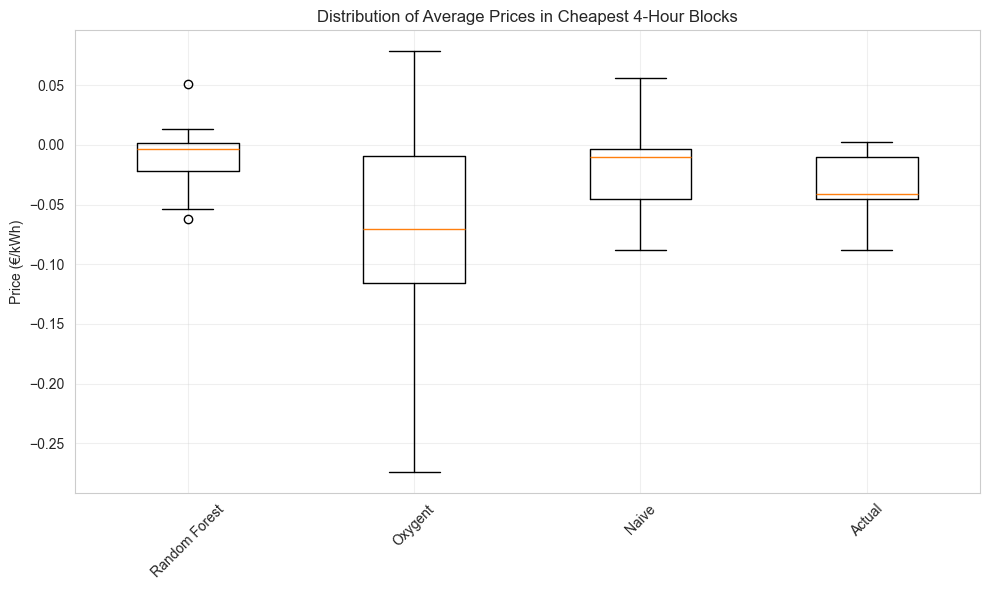


Mean Prices in Cheapest 4-Hour Blocks:
Random Forest: €-0.0097/kWh
Oxygent: €-0.0686/kWh
Naive: €-0.0290/kWh
Actual: €-0.0375/kWh


In [46]:
import matplotlib.pyplot as plt

# Initialize results dictionary
avg_prices = {
    'Random Forest': [],
    'Oxygent': [],
    'Naive': [],
    'Actual': []
}

# Get unique run dates
run_dates = df['run_date'].unique()

# For each run date
for run_date in run_dates:
    day_data = df[df['run_date'] == run_date]
    
    # Calculate rolling means for each model and actual prices
    for model, column in [('Random Forest', 'predicted_Price'), 
                         ('Oxygent', 'oxygent_price'), 
                         ('Naive', 'naive_price'),
                         ('Actual', 'actual_Price')]:
        
        # Calculate rolling mean for 4-hour blocks
        rolling_means = day_data[column].rolling(window=4).mean()
        
        # Find cheapest block
        min_idx = rolling_means.idxmin()
        if pd.notna(min_idx):  # Check if valid index found
            # Get the 4-hour block
            block = day_data.loc[min_idx-3:min_idx]
            # Calculate average price for this block
            avg_price = block[column].mean()
            avg_prices[model].append(avg_price)

# Create box plot
plt.figure(figsize=(10, 6))
plt.boxplot([avg_prices[model] for model in avg_prices.keys()], 
            labels=avg_prices.keys(),
            whis=1.5)

plt.title('Distribution of Average Prices in Cheapest 4-Hour Blocks')
plt.ylabel('Price (€/kWh)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nMean Prices in Cheapest 4-Hour Blocks:")
print("=======================================")
for model in avg_prices.keys():
    mean_price = np.mean(avg_prices[model])
    print(f"{model}: €{mean_price:.4f}/kWh")

In [47]:
# Calculate average prices for each model and actual prices
avg_prices = {
    'Random Forest': df['predicted_Price'].mean(),
    'Oxygent': df['oxygent_price'].mean(),
    'Naive': df['naive_price'].mean(),
    'Actual': df['actual_Price'].mean()
}

# Create a DataFrame for better formatting
avg_prices_df = pd.DataFrame({
    'Model': list(avg_prices.keys()),
    'Average Price (€/kWh)': list(avg_prices.values())
}).round(6)

print("\nAverage Prices by Model:")
print("=======================")
print(avg_prices_df)


Average Prices by Model:
           Model  Average Price (€/kWh)
0  Random Forest               0.079937
1        Oxygent               0.083073
2          Naive               0.083316
3         Actual               0.076805


In [48]:
# Convert target_datetime to datetime if it's not already
df['target_datetime'] = pd.to_datetime(df['target_datetime'])

# Define the weeks
weeks = [
    ('Week 1', '2024-03-15', '2024-03-21'),
    ('Week 2', '2024-03-22', '2024-03-28'),
    ('Week 3', '2024-03-29', '2024-04-04'),
    ('Week 4', '2024-04-05', '2024-04-11'),
    ('Week 5', '2024-04-12', '2024-04-18')
]

# Initialize results dictionary
results = {}

for week_name, start_date, end_date in weeks:
    # Filter data for the week
    week_data = df[(df['target_datetime'] >= start_date) & 
                   (df['target_datetime'] <= end_date)]
    
    # Calculate rolling mean for 4-hour blocks
    rolling_means = week_data['actual_Price'].rolling(window=4).mean()
    
    # Get the three lowest 4-hour blocks
    lowest_blocks = []
    for i in range(3):  # Get top 3
        if len(rolling_means) >= 4:  # Check if there's enough data
            min_idx = rolling_means.idxmin()
            if min_idx is not None:  # Check if valid index found
                block_data = week_data.loc[min_idx:min_idx+3]
                block_mean = block_data['actual_Price'].mean()
                block_start = block_data.iloc[0]['target_datetime']
                lowest_blocks.append({
                    'start_time': block_start,
                    'average_price': block_mean
                })
                # Mask this block to find next lowest
                rolling_means.loc[min_idx:min_idx+3] = float('inf')
    
    results[week_name] = lowest_blocks

# Print results
for week, blocks in results.items():
    print(f"\n{week}:")
    for i, block in enumerate(blocks, 1):
        print(f"Block {i}:")
        print(f"Start time: {block['start_time'].strftime('%Y-%m-%d %H:%M')}")
        print(f"Average price: €{block['average_price']:.2f}/MWh")


Week 1:

Week 2:

Week 3:

Week 4:

Week 5:


Forecast hours range from 25 to 168


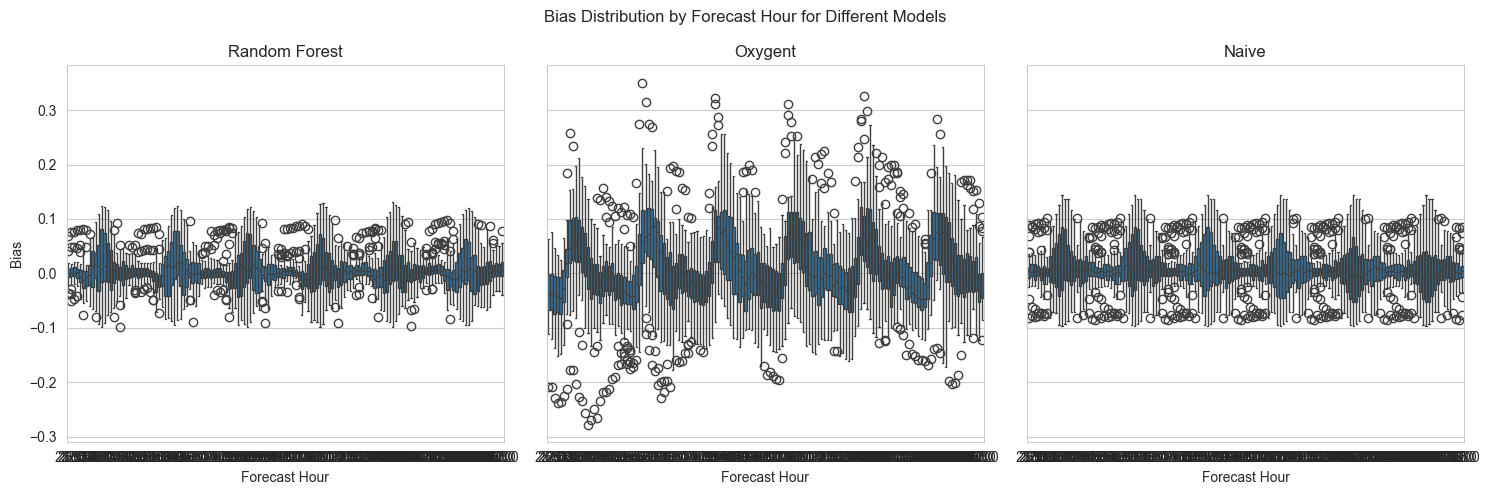

In [49]:
import seaborn as sns

import matplotlib.pyplot as plt

# 1. Add forecast_hour column
df['forecast_hour'] = (pd.to_datetime(df['target_datetime']) - pd.to_datetime(df['run_date'])).dt.total_seconds()/3600

# 2. Get min and max forecast hours
min_hour = df['forecast_hour'].min()
max_hour = df['forecast_hour'].max()
print(f"Forecast hours range from {min_hour:.0f} to {max_hour:.0f}")

# 3. Calculate bias and create plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Bias Distribution by Forecast Hour for Different Models')

models = ['predicted_Price', 'oxygent_price', 'naive_price']
names = ['Random Forest', 'Oxygent', 'Naive']

for i, (model, name) in enumerate(zip(models, names)):
    # Calculate bias
    df[f'bias_{model}'] = df[model] - df['actual_Price']
    
    # Create boxplot
    sns.boxplot(data=df, x='forecast_hour', y=f'bias_{model}', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Forecast Hour')
    axes[i].set_ylabel('Bias' if i==0 else '')
    
plt.tight_layout()

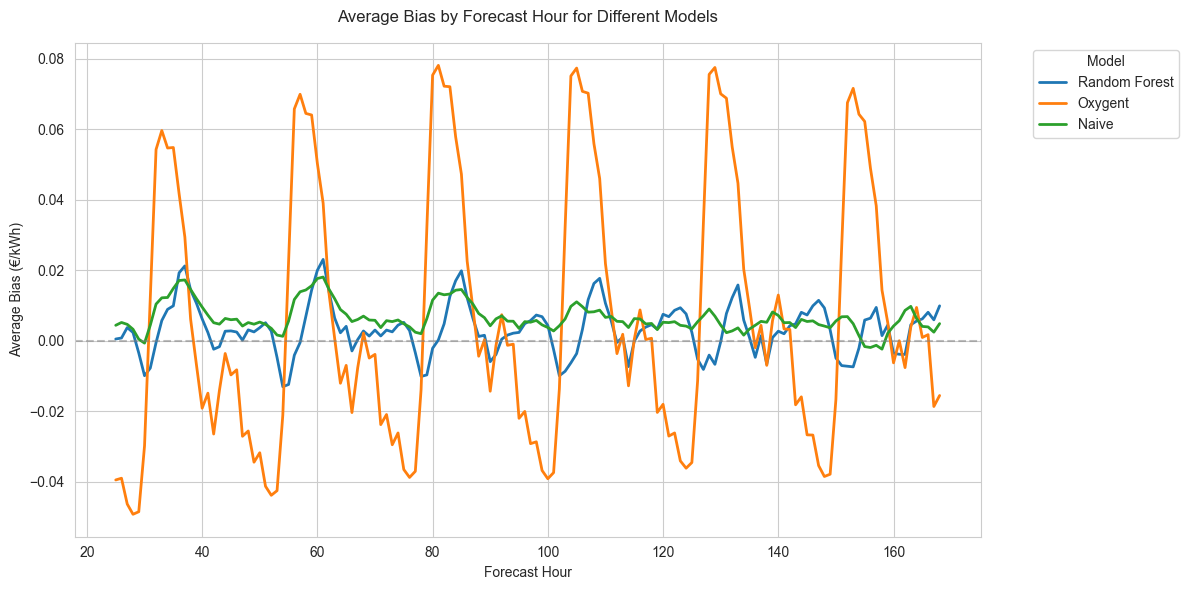

In [50]:
# Calculate mean bias per forecast hour for each model
bias_by_hour = pd.DataFrame({
    'Random Forest': df.groupby('forecast_hour')['bias_predicted_Price'].mean(),
    'Oxygent': df.groupby('forecast_hour')['bias_oxygent_price'].mean(),
    'Naive': df.groupby('forecast_hour')['bias_naive_price'].mean()
})

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot lines for each model
for column in bias_by_hour.columns:
    plt.plot(bias_by_hour.index, bias_by_hour[column], label=column, linewidth=2)

# Add horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Customize the plot
plt.title('Average Bias by Forecast Hour for Different Models', fontsize=12, pad=15)
plt.xlabel('Forecast Hour', fontsize=10)
plt.ylabel('Average Bias (€/kWh)', fontsize=10)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

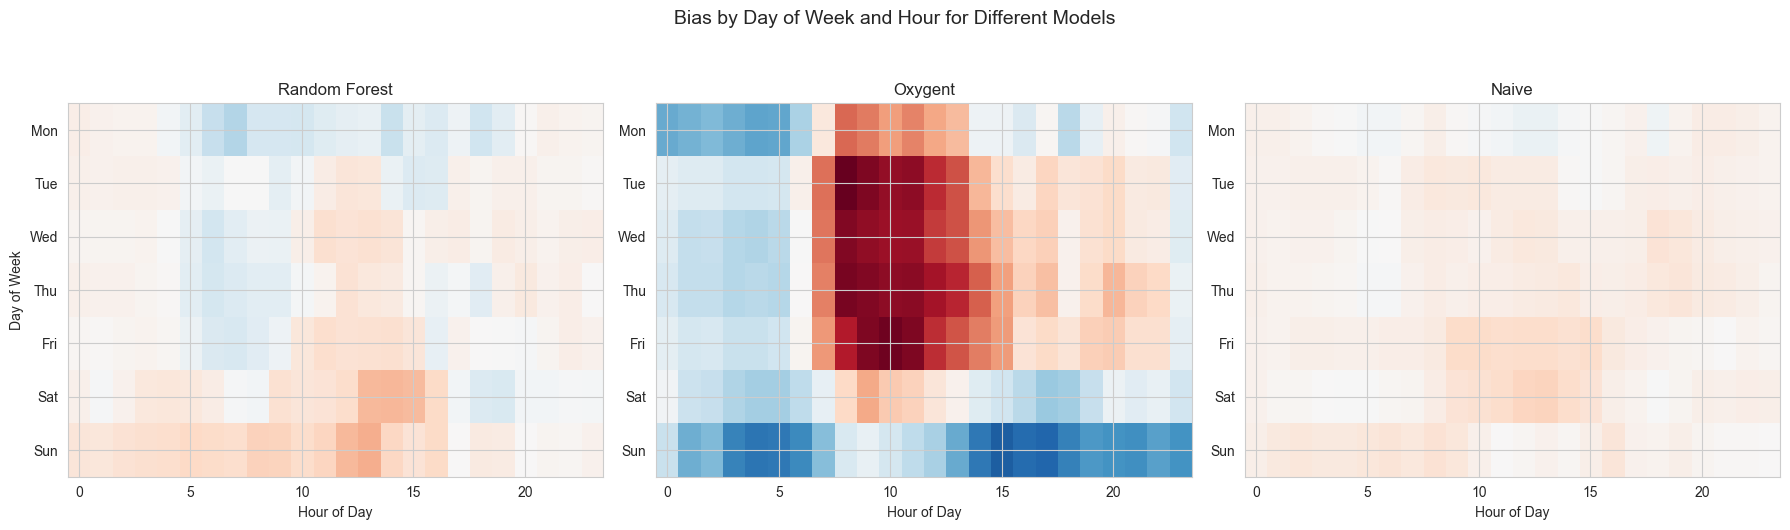

In [51]:
# Convert target_datetime to datetime and extract day of week and hour
df['day_of_week'] = pd.to_datetime(df['target_datetime']).dt.dayofweek
df['hour'] = pd.to_datetime(df['target_datetime']).dt.hour

# Calculate mean bias per day and hour for each model
bias_by_dayhour = pd.DataFrame()
for day in range(7):
    for hr in range(24):
        mask = (df['day_of_week'] == day) & (df['hour'] == hr)
        bias_by_dayhour.loc[f"{day}_{hr}", 'Random Forest'] = df[mask]['bias_predicted_Price'].mean()
        bias_by_dayhour.loc[f"{day}_{hr}", 'Oxygent'] = df[mask]['bias_oxygent_price'].mean()
        bias_by_dayhour.loc[f"{day}_{hr}", 'Naive'] = df[mask]['bias_naive_price'].mean()

# Create heatmap subplots for each model
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Bias by Day of Week and Hour for Different Models', fontsize=14, y=1.05)

models = ['Random Forest', 'Oxygent', 'Naive']
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Calculate global vmax for symmetric color scaling
vmax = max(abs(bias_by_dayhour.min().min()), abs(bias_by_dayhour.max().max()))

for i, (model, ax) in enumerate(zip(models, axes)):
    # Reshape data for heatmap: rows=days, columns=hours
    data = np.array([bias_by_dayhour[model][bias_by_dayhour.index.str.startswith(f"{d}_")].values for d in range(7)])
    ax.imshow(data, aspect='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    ax.set_title(model)
    ax.set_yticks(range(7))
    ax.set_yticklabels(day_labels)
    ax.set_xlabel('Hour of Day')
    if i == 0:
        ax.set_ylabel('Day of Week')

plt.tight_layout()
plt.show()

legend: colour scheme runs from -0.10 to + 0.10 € (darkest blue to darkest red)

## Model Performance Comparison

### Comparison Strategy

To evaluate the effectiveness of our Random Forest-based price forecasting model, we benchmarked its performance against two reference models: a naive model (using a simple persistence strategy) and an external benchmark model (Oxygent). The assessment focuses on three key aspects: overall forecast accuracy (Root Mean Squared Error, RMSE), bias across the forecast horizon, and practical utility in identifying the most and least expensive hours for electricity consumption.

---

### Overall Performance (RMSE)

The Random Forest model consistently outperforms both the naive and Oxygent models in terms of RMSE, indicating more accurate price predictions across the entire test set. RMSE values were calculated for each model using all available forecasted hours, providing a robust measure of average prediction error. This demonstrates the added value of the Random Forest approach over both simple and external benchmarks.

---

### Bias Analysis Across the Forecast Horizon

To further understand model behavior, we analyzed the bias (mean prediction error) as a function of the forecast horizon (in hours). The Random Forest model exhibits lower and more stable bias across different forecast horizons compared to the reference models, suggesting that its predictions are less systematically over- or underestimating actual prices. This stability is crucial for operational planning, as it reduces the risk of persistent over- or under-forecasting at specific lead times.

---

### Practical Performance: Identifying Cheapest and Most Expensive Hours

Beyond aggregate error metrics, we assessed each model’s ability to identify the 4 cheapest and 4 most expensive hours per day—a practical task for optimizing consumption or trading strategies. The Random Forest model achieves a higher average overlap with the actual cheapest and most expensive hours, and its selected hours are closer in price to the true optimal periods. This demonstrates that the model’s predictions are not only statistically accurate but also actionable in real-world decision-making contexts.

---

### Time-Dependent Error Patterns

To explore potential time-dependent error patterns, a bias heatmap by day of the week and hour of the day will be included. This visualization will help identify if certain periods (e.g., specific weekdays or hours) are associated with systematic over- or under-prediction, providing insights for further model refinement.

---

### Illustrative Example: Representative Week

Finally, a representative example week will be presented, showing model predictions versus actual prices for a range of `target_datetime` values within a single forecast run. This example will illustrate the day-to-day and hour-to-hour performance of each model, highlighting strengths and any remaining challenges in real-world forecasting scenarios.

---

**In summary, the Random Forest model demonstrates superior accuracy, lower bias, and greater practical utility compared to both the naive and Oxygent benchmarks, making it a robust choice for electricity price forecasting.**

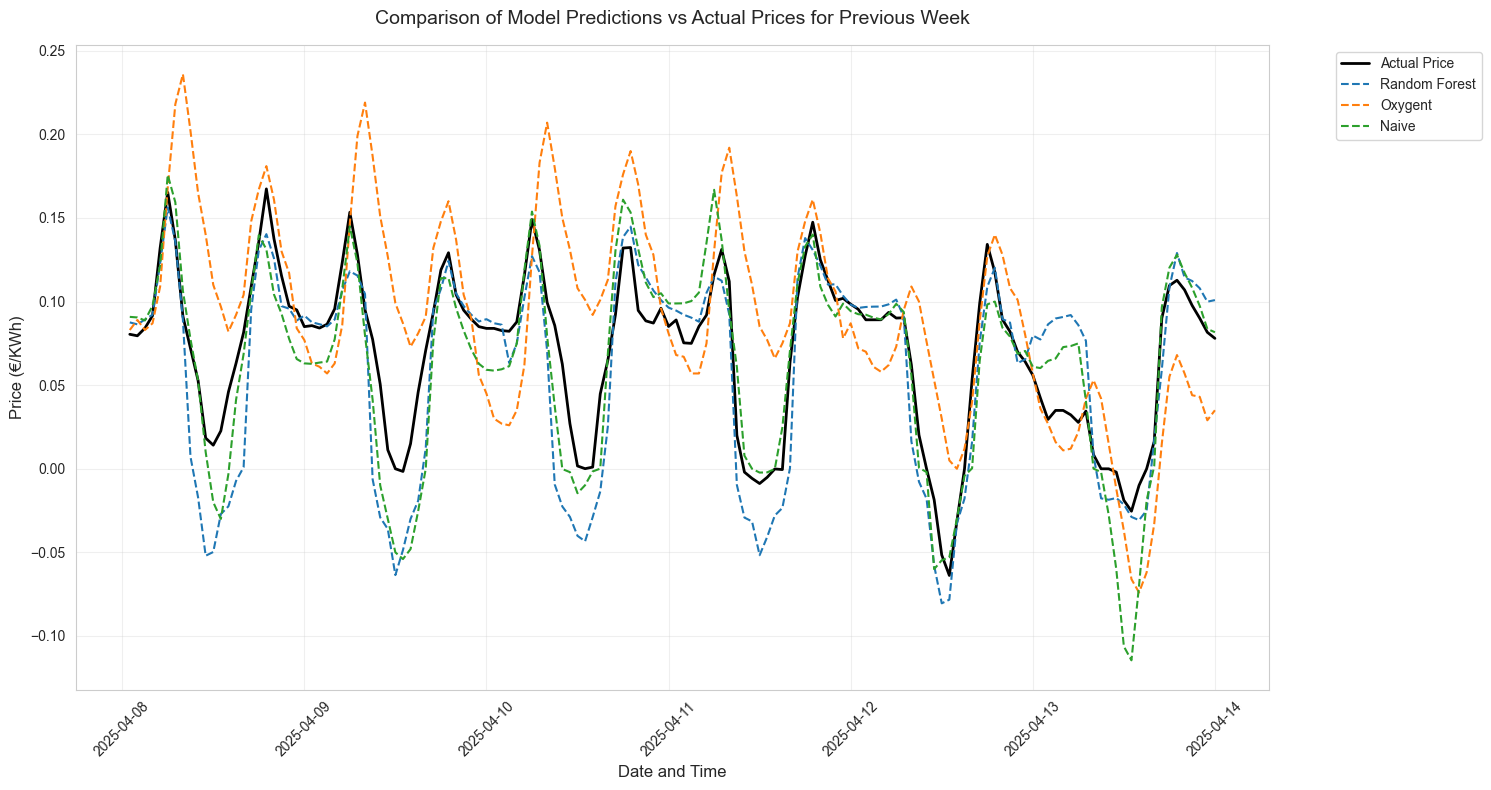


Summary Statistics for Previous Week:

Random Forest:
RMSE: 0.0325
Bias: -0.0120

Oxygent:
RMSE: 0.0569
Bias: 0.0223

Naive:
RMSE: 0.0277
Bias: -0.0079


In [53]:
# Select data from 6 days earlier than the last week
second_last_week = df[df['run_date'] == df['run_date'].unique()[-7]]  # -7 instead of -1
second_last_week = second_last_week.sort_values('target_datetime')

plt.figure(figsize=(15, 8))

# Plot actual prices
plt.plot(pd.to_datetime(second_last_week['target_datetime']), second_last_week['actual_Price'], 
         label='Actual Price', color='black', linewidth=2)

# Plot model predictions
plt.plot(pd.to_datetime(second_last_week['target_datetime']), second_last_week['predicted_Price'], 
         label='Random Forest', linestyle='--')
plt.plot(pd.to_datetime(second_last_week['target_datetime']), second_last_week['oxygent_price'], 
         label='Oxygent', linestyle='--')
plt.plot(pd.to_datetime(second_last_week['target_datetime']), second_last_week['naive_price'], 
         label='Naive', linestyle='--')

plt.title('Comparison of Model Predictions vs Actual Prices for Previous Week', 
          fontsize=14, pad=15)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Price (€/KWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Format x-axis to show date and weekday
ax = plt.gca()
import matplotlib.dates as mdates

# Select data from 6 days earlier than the last week
second_last_week = df[df['run_date'] == df['run_date'].unique()[-7]]  # -7 instead of -1

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics for this period
print("\nSummary Statistics for Previous Week:")
print("===========================================")
for model in ['Random Forest', 'Oxygent', 'Naive']:
    if model == 'Random Forest':
        pred_col = 'predicted_Price'
    elif model == 'Oxygent':
        pred_col = 'oxygent_price'
    else:
        pred_col = 'naive_price'
        
    rmse = np.sqrt(mean_squared_error(second_last_week['actual_Price'], second_last_week[pred_col]))
    mae = mean_absolute_error(second_last_week['actual_Price'], second_last_week[pred_col])
    bias = (second_last_week[pred_col] - second_last_week['actual_Price']).mean()
    
    print(f"\n{model}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"Bias: {bias:.4f}")


Charging Scenario Analysis:
          Scenario  Total Cost (€)  Absolute Savings (€)  Relative Savings (%)
0     Fixed Tariff           75.06                  0.00                  0.00
1    Average Price           60.42                 14.63                 19.50
2  Weekly Charging           22.24                 52.81                 70.36
3   4-Day Charging           44.63                 30.43                 40.54


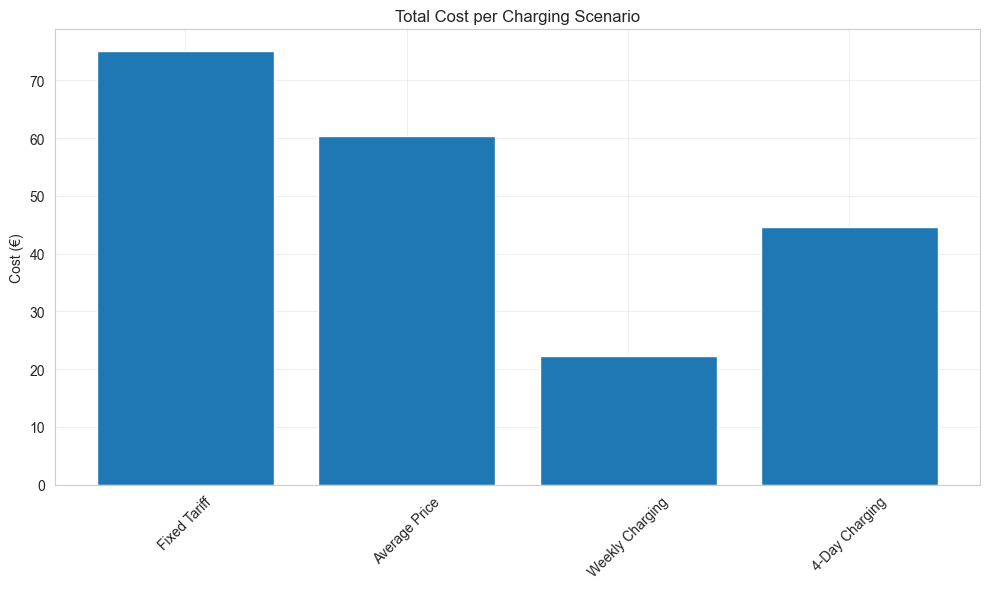

In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

def calculate_charging_scenarios():
    # Helper function to calculate adjusted price
    def adjusted_price(price):
        return (price + 0.10154) * 1.21
    
    # Scenario 1: Fixed tariff
    fixed_tariff = 0.12
    scenario1_cost = 280 * adjusted_price(fixed_tariff)
    
    # Scenario 2: Average price
    avg_price = df['actual_Price'].mean()
    scenario2_cost = 280 * adjusted_price(avg_price)
    
    # Scenario 3: Weekly charging (140 kWh total, 28 kWh per week)
    scenario3_cost = 0
    start_date = df['target_datetime'].min()
    weeks = pd.date_range(start=start_date, periods=5, freq='7D')
    
    for week_start in weeks:
        week_end = week_start + pd.Timedelta(days=7)
        week_data = df[(df['target_datetime'] >= week_start) & 
                      (df['target_datetime'] < week_end)]
        
        # Find cheapest 4-hour block in the week
        rolling_mean = week_data['actual_Price'].rolling(window=4).mean()
        cheapest_start_idx = rolling_mean.idxmin()
        if pd.notna(cheapest_start_idx):
            cheapest_block = week_data.loc[cheapest_start_idx:cheapest_start_idx+3]
            block_prices = cheapest_block['actual_Price'].apply(adjusted_price)
            scenario3_cost += (28/4) * block_prices.sum()  # 7 kWh per hour
    
    # Scenario 4: 4-day periods (280 kWh total, 31.1 kWh per period)
    scenario4_cost = 0
    periods = pd.date_range(start=start_date, periods=9, freq='4D')
    
    for period_start in periods:
        period_end = period_start + pd.Timedelta(days=4)
        period_data = df[(df['target_datetime'] >= period_start) & 
                        (df['target_datetime'] < period_end)]
        
        # Find cheapest 4-hour block in the period
        rolling_mean = period_data['actual_Price'].rolling(window=4).mean()
        cheapest_start_idx = rolling_mean.idxmin()
        if pd.notna(cheapest_start_idx):
            cheapest_block = period_data.loc[cheapest_start_idx:cheapest_start_idx+3]
            block_prices = cheapest_block['actual_Price'].apply(adjusted_price)
            scenario4_cost += (31.1/4) * block_prices.sum()  # 7.775 kWh per hour
    
    # Create results DataFrame
    results = pd.DataFrame({
        'Scenario': ['Fixed Tariff', 'Average Price', 'Weekly Charging', '4-Day Charging'],
        'Total Cost (€)': [scenario1_cost, scenario2_cost, scenario3_cost, scenario4_cost]
    })
    
    # Calculate savings
    results['Absolute Savings (€)'] = results['Total Cost (€)'][0] - results['Total Cost (€)']
    results['Relative Savings (%)'] = (results['Absolute Savings (€)'] / results['Total Cost (€)'][0] * 100)
    
    # Round results
    results = results.round(2)
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(results['Scenario'], results['Total Cost (€)'])
    plt.title('Total Cost per Charging Scenario')
    plt.ylabel('Cost (€)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return results

# Run the analysis
results = calculate_charging_scenarios()
print("\nCharging Scenario Analysis:")
print("==========================")
print(results)

In [55]:
def analyze_charging_windows():
    # Helper function to calculate adjusted price
    def adjusted_price(price):
        return (price + 0.10154) * 1.21
    
    # Initialize output DataFrames
    weekly_blocks_df = pd.DataFrame(columns=['block_start', 'selected_hours', 'avg_price', 'total_cost'])
    fourday_blocks_df = pd.DataFrame(columns=['block_start', 'selected_hours', 'avg_price', 'total_cost'])
    
    # Get min and max dates to establish windows
    min_date = pd.to_datetime(df['target_datetime']).min()
    max_date = pd.to_datetime(df['target_datetime']).max()
    
    # Create weekly windows
    weekly_starts = pd.date_range(start=min_date, end=max_date, freq='7D')
    for start in weekly_starts:
        end = start + pd.Timedelta(days=7)
        window_data = df[(pd.to_datetime(df['target_datetime']) >= start) & 
                        (pd.to_datetime(df['target_datetime']) < end)]
        
        if not window_data.empty:
            # Find cheapest 4-hour block using rolling mean
            rolling_mean = window_data['actual_Price'].rolling(window=4).mean()
            if not rolling_mean.empty:
                min_idx = rolling_mean.idxmin()
                if pd.notna(min_idx):
                    block = window_data.loc[min_idx:min_idx+3]
                    adj_prices = block['actual_Price'].apply(adjusted_price)
                    avg_adj_price = adj_prices.mean()
                    total_cost = avg_adj_price * 28  # 28 kWh total for weekly block
                    
                    weekly_blocks_df = pd.concat([weekly_blocks_df, pd.DataFrame({
                        'block_start': [start],
                        'selected_hours': [block['target_datetime'].tolist()],
                        'avg_price': [avg_adj_price],
                        'total_cost': [total_cost]
                    })])
    
    # Create 4-day windows
    fourday_starts = pd.date_range(start=min_date, end=max_date, freq='4D')
    for start in fourday_starts:
        end = start + pd.Timedelta(days=4)
        window_data = df[(pd.to_datetime(df['target_datetime']) >= start) & 
                        (pd.to_datetime(df['target_datetime']) < end)]
        
        if not window_data.empty:
            # Find cheapest 4-hour block using rolling mean
            rolling_mean = window_data['actual_Price'].rolling(window=4).mean()
            if not rolling_mean.empty:
                min_idx = rolling_mean.idxmin()
                if pd.notna(min_idx):
                    block = window_data.loc[min_idx:min_idx+3]
                    adj_prices = block['actual_Price'].apply(adjusted_price)
                    avg_adj_price = adj_prices.mean()
                    total_cost = avg_adj_price * 31.1  # 31.1 kWh total for 4-day block
                    
                    fourday_blocks_df = pd.concat([fourday_blocks_df, pd.DataFrame({
                        'block_start': [start],
                        'selected_hours': [block['target_datetime'].tolist()],
                        'avg_price': [avg_adj_price],
                        'total_cost': [total_cost]
                    })])
    
    # Reset indexes
    weekly_blocks_df = weekly_blocks_df.reset_index(drop=True)
    fourday_blocks_df = fourday_blocks_df.reset_index(drop=True)
    
    # Calculate summary statistics
    weekly_total = weekly_blocks_df['total_cost'].sum()
    fourday_total = fourday_blocks_df['total_cost'].sum()
    
    print(f"\nWeekly Charging Summary:")
    print(f"Total Cost: €{weekly_total:.2f}")
    print(f"Average Cost per Block: €{weekly_blocks_df['total_cost'].mean():.2f}")
    
    print(f"\n4-Day Charging Summary:")
    print(f"Total Cost: €{fourday_total:.2f}")
    print(f"Average Cost per Block: €{fourday_blocks_df['total_cost'].mean():.2f}")
    
    return weekly_blocks_df, fourday_blocks_df

# Run the analysis
weekly_df, fourday_df = analyze_charging_windows()


Weekly Charging Summary:
Total Cost: €22.24
Average Cost per Block: €4.45

4-Day Charging Summary:
Total Cost: €44.63
Average Cost per Block: €4.96


/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_22602/1140164204.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weekly_blocks_df = pd.concat([weekly_blocks_df, pd.DataFrame({
/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_22602/1140164204.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fourday_blocks_df = pd.concat([fourday_blocks_df, pd.DataFrame({


In [58]:
# Summary: This cell defines and runs a function to evaluate how well each model
# predicts cost savings using cheapest 4-hour blocks per window. It calculates model costs,
# overlap with actual blocks, and RMSE within selected hours.

from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

def analyze_model_predictions(df):
    # Helper function to calculate adjusted price
    def adjusted_price(price):
        return (price + 0.10154) * 1.21
    
    # Initialize results
    weekly_results = []
    fourday_results = []
    
    model_columns = {
        'Random Forest': 'predicted_Price',
        'Oxygent': 'oxygent_price',
        'Naive': 'naive_price'
    }
    
    scenarios = {
        'Weekly': {'days': 7, 'consumption': 7.0},     # 7 kWh/hour × 4 = 28 kWh
        '4-day': {'days': 4, 'consumption': 7.775}     # 7.775 kWh/hour × 4 = 31.1 kWh
    }
    
    min_date = pd.to_datetime(df['target_datetime']).min()
    max_date = pd.to_datetime(df['target_datetime']).max()
    
    for scenario, params in scenarios.items():
        window_starts = pd.date_range(start=min_date, end=max_date, freq=f"{params['days']}D")
        
        for start in window_starts:
            end = start + pd.Timedelta(days=params['days'])
            window_data = df[(pd.to_datetime(df['target_datetime']) >= start) & 
                             (pd.to_datetime(df['target_datetime']) < end)].copy()
            
            if len(window_data) < 4:
                continue  # skip short windows
            
            # Find actual cheapest block
            actual_rolling = window_data['actual_Price'].rolling(window=4).mean()
            actual_min_idx = actual_rolling.idxmin()
            if pd.notna(actual_min_idx):
                actual_block = window_data.loc[actual_min_idx:actual_min_idx+3]
                actual_block_hours = set(actual_block.index)
                actual_cost = sum(adjusted_price(actual_block['actual_Price']) * params['consumption'])
                
                for model_name, column in model_columns.items():
                    model_rolling = window_data[column].rolling(window=4).mean()
                    model_min_idx = model_rolling.idxmin()
                    
                    if pd.notna(model_min_idx):
                        model_block = window_data.loc[model_min_idx:model_min_idx+3]
                        model_block_hours = set(model_block.index)
                        
                        overlap = len(model_block_hours & actual_block_hours)
                        model_cost = sum(adjusted_price(model_block['actual_Price']) * params['consumption'])
                        rmse = np.sqrt(mean_squared_error(model_block['actual_Price'], 
                                                          model_block[column]))
                        
                        result = {
                            'Model': model_name,
                            'Scenario': scenario,
                            'Window Start': start,
                            'Model Cost (€)': round(model_cost, 2),
                            'True Block Cost (€)': round(actual_cost, 2),
                            'Cost Diff (€)': round(model_cost - actual_cost, 2),
                            'Overlap (hrs)': overlap,
                            'RMSE': round(rmse, 5)
                        }
                        
                        if scenario == 'Weekly':
                            weekly_results.append(result)
                        else:
                            fourday_results.append(result)

    # Convert to DataFrames
    weekly_results_df = pd.DataFrame(weekly_results)
    fourday_results_df = pd.DataFrame(fourday_results)
    
    # Print summary statistics
    for scenario, df_result in [('Weekly', weekly_results_df), ('4-day', fourday_results_df)]:
        print(f"\n{scenario} Scenario Summary:")
        print("============================")
        summary = df_result.groupby('Model').agg({
            'Cost Diff (€)': ['mean', 'std'],
            'Overlap (hrs)': 'mean',
            'RMSE': 'mean'
        }).round(4)
        print(summary)
    
    return weekly_results_df, fourday_results_df

# Run the analysis
weekly_results_df, fourday_results_df = analyze_model_predictions(df)


Weekly Scenario Summary:
              Cost Diff (€)         Overlap (hrs)    RMSE
                       mean     std          mean    mean
Model                                                    
Naive                 0.366  0.9746           0.8  0.0248
Oxygent               0.878  0.6572           0.0  0.1346
Random Forest         0.652  0.4197           0.6  0.0276

4-day Scenario Summary:
              Cost Diff (€)         Overlap (hrs)    RMSE
                       mean     std          mean    mean
Model                                                    
Naive                0.5689  0.8344        1.3333  0.0275
Oxygent              1.6767  0.6982        0.0000  0.1175
Random Forest        1.4289  1.3864        0.3333  0.0351


/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_22602/2647223173.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_22602/2647223173.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_22602/2647223173.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_22602/2647223173.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

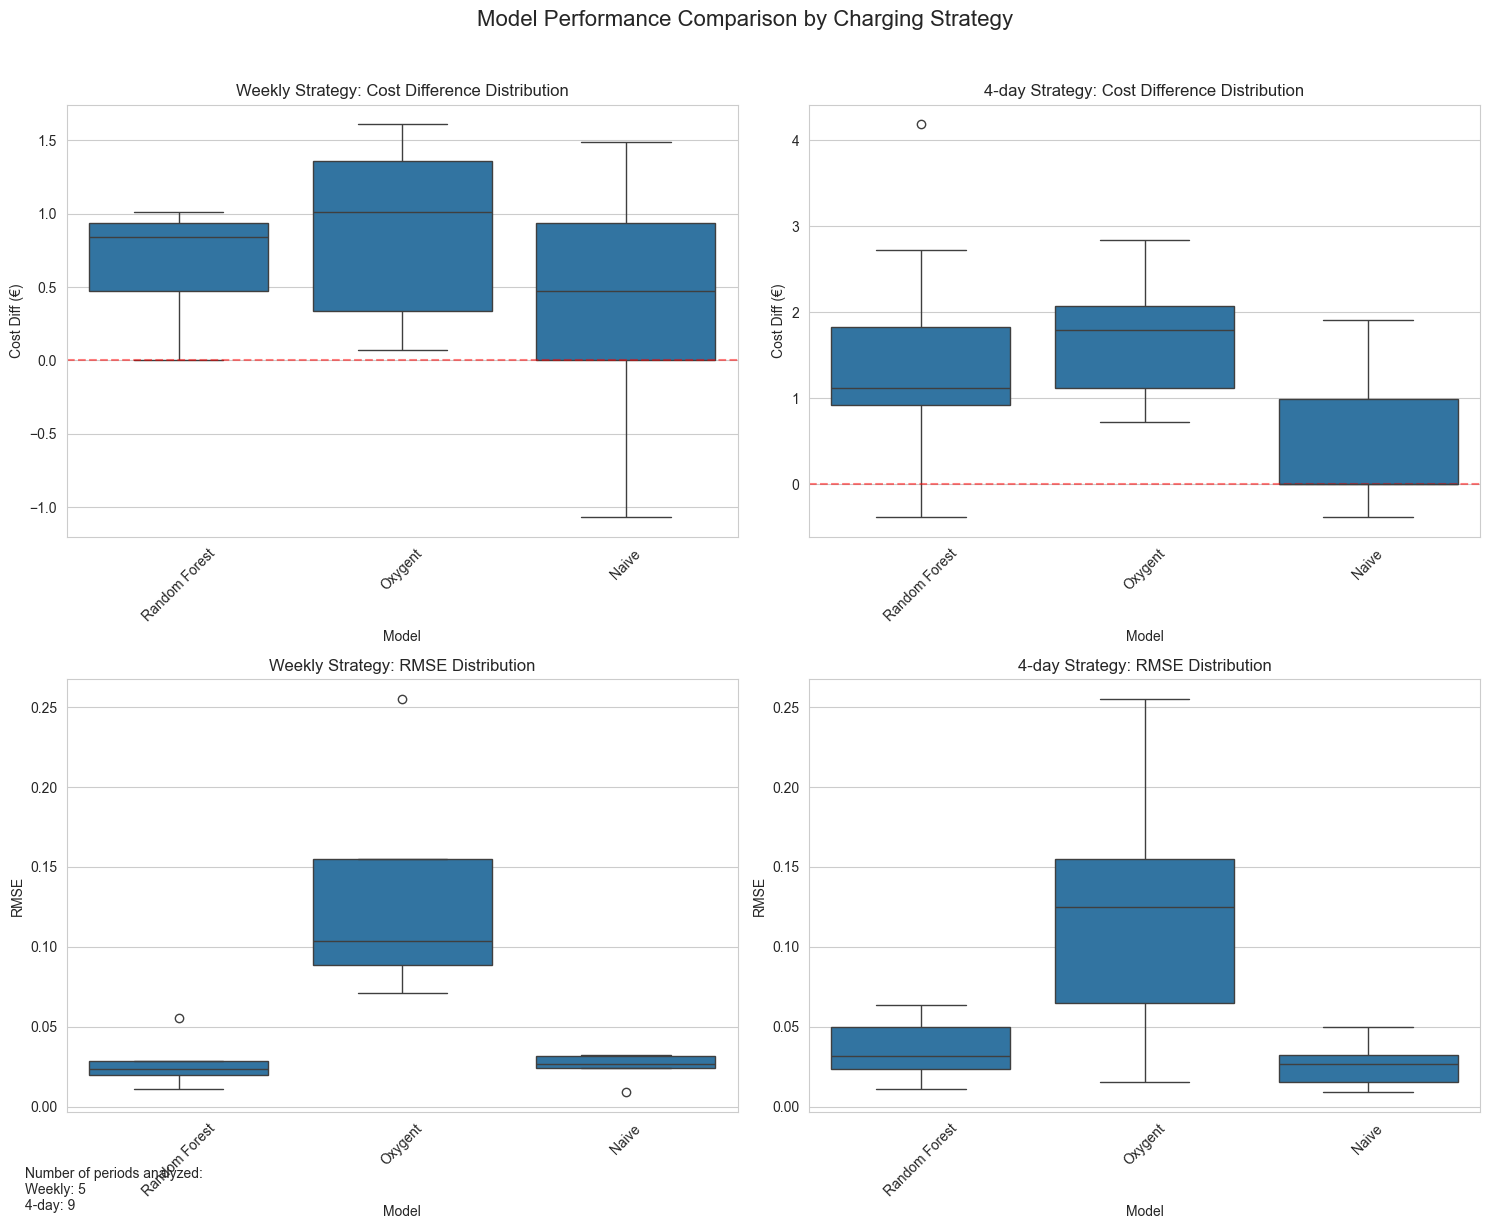


Summary Statistics:

Weekly Strategy:
              Cost Diff (€)          RMSE       
                       mean    std   mean    std
Model                                           
Naive                 0.366  0.975  0.025  0.010
Oxygent               0.878  0.657  0.135  0.074
Random Forest         0.652  0.420  0.028  0.017

4-day Strategy:
              Cost Diff (€)          RMSE       
                       mean    std   mean    std
Model                                           
Naive                 0.569  0.834  0.027  0.014
Oxygent               1.677  0.698  0.117  0.073
Random Forest         1.429  1.386  0.035  0.018


In [ ]:
# Summary: This cell generates visual summaries of model prediction performance per scenario.
# It visualizes cost difference, overlap with actual blocks, and RMSE per model for both Weekly and 4-day charging strategies.

import pandas as pd

import matplotlib.pyplot as plt

# Create figure with subplots for different metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Comparison by Charging Strategy', fontsize=16, y=1.02)

# Plot Cost Difference Distribution - Weekly
sns.boxplot(data=weekly_results_df, x='Model', y='Cost Diff (€)', ax=axes[0,0])
axes[0,0].set_title('Weekly Strategy: Cost Difference Distribution')
axes[0,0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot Cost Difference Distribution - 4-day
sns.boxplot(data=fourday_results_df, x='Model', y='Cost Diff (€)', ax=axes[0,1])
axes[0,1].set_title('4-day Strategy: Cost Difference Distribution')
axes[0,1].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot RMSE Distribution - Weekly
sns.boxplot(data=weekly_results_df, x='Model', y='RMSE', ax=axes[1,0])
axes[1,0].set_title('Weekly Strategy: RMSE Distribution')

# Plot RMSE Distribution - 4-day
sns.boxplot(data=fourday_results_df, x='Model', y='RMSE', ax=axes[1,1])
axes[1,1].set_title('4-day Strategy: RMSE Distribution')

# Rotate x-axis labels
for ax in axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Add overall statistics as text
plt.figtext(0.02, 0.02, 
            f"Number of periods analyzed:\nWeekly: {len(weekly_results_df)//3}\n4-day: {len(fourday_results_df)//3}", 
            fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("==================")
for strategy, df in [("Weekly", weekly_results_df), ("4-day", fourday_results_df)]:
    print(f"\n{strategy} Strategy:")
    summary = df.groupby('Model').agg({
        'Cost Diff (€)': ['mean', 'std'],
        'RMSE': ['mean', 'std']
    }).round(3)
    print(summary)